# Task 3: Transfer Learning

In [1]:
import importlib
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomBrightness, RandomContrast, RandomRotation, Conv2D, Flatten, Dense 

import src.loading as loading
import src.models as models
import src.preprocessing as preprocessing

importlib.reload(loading)
importlib.reload(models)

<module 'src.models' from 'c:\\Users\\wille\\AI-project\\notebooks\\src\\models.py'>

## 1. Set up the classification

In [2]:
# Choose a metric to evaluate the succes of the classifier.
metrics=['accuracy']

In [3]:
# Set a seed for NumPy and Keras for preproducibility.
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Set up image generators for the training, validation, and test data.
img_height, img_width = 128, 128
batch_size = 32
path = "../data"
train_data_gen, val_data_gen, train_and_val_data_gen, test_data_gen = loading.get_images(path, img_height, img_width, batch_size, norm="training", color_mode="rgb")

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


## 2. Setup the base model

In [5]:
# Instantiate the base model with the "imagenet" pre-trained weights, not including the top layers.
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

In [6]:
# Freeze all layers in the base model.
base_model.trainable = False

In [7]:
# Select best parameters from baseline

results_csv = "../results/hyperparameter_tuning_results_baseline.csv"
df_results = pd.read_csv(results_csv)

best_config = df_results.sort_values('best_val_accuracy', ascending=False).iloc[0]
#best_batch_size = int(best_config['batch_size'])
best_lr = best_config['learning_rate']
best_dropout = best_config['dropout_rate']

print("Best Hyperparameters:")
print(best_config)

Best Hyperparameters:
dropout_rate           0.100000
first_filters         16.000000
learning_rate          0.000500
dense_units          256.000000
best_val_accuracy      0.895833
best_epoch            11.000000
final_val_loss         0.308976
Name: 3, dtype: float64


In [78]:
# Add fully connected layers to the base model for the classification task.
model = models.transfer_model(
    base_model,
    dropout_rate = 0.1,
    dense_unit = 256,
    lr =0.0005,
    metrics=metrics)

In [79]:
# Print the final architecture.
model.summary()

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 4, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,155,393 (92.15 MB)

 Trainable params: 590,593 (2.25 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

## 3. Training the model

In [30]:
total_train = train_data_gen.samples
total_val = val_data_gen.samples

print(f"total_train: {total_train}")
print(f"total_val: {total_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train // batch_size}")

total_train: 1600
total_val: 400
batch_size: 32
steps_per_epoch: 50


In [80]:
# Training the model.
epochs = 30

history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/30


50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 579ms/step - accuracy: 0.5001 - loss: 1.5788 - val_accuracy: 0.6172 - val_loss: 0.6784
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 531ms/step - accuracy: 0.5611 - loss: 0.8689 - val_accuracy: 0.6901 - val_loss: 0.6361
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 543ms/step - accuracy: 0.5364 - loss: 0.7410 - val_accuracy: 0.7083 - val_loss: 0.7627
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 532ms/step - accuracy: 0.5545 - loss: 0.7142 - val_accuracy: 0.6536 - val_loss: 0.6708
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 29s 575ms/step - accuracy: 0.5508 - loss: 0.7129 - val_accuracy: 0.5885 - val_loss: 0.7192
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 28s 566ms/step - accuracy: 0.5268 - loss: 0.7158 - val_accuracy: 0.6042 - val_loss: 0.7503
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 608ms/step - accuracy: 0.5555 - loss: 0.6693 - val_accuracy: 0.5964 - val_loss: 1.0050
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 593ms/step - accuracy: 0.6137 - loss: 0.6261 - val_accuracy: 0.695

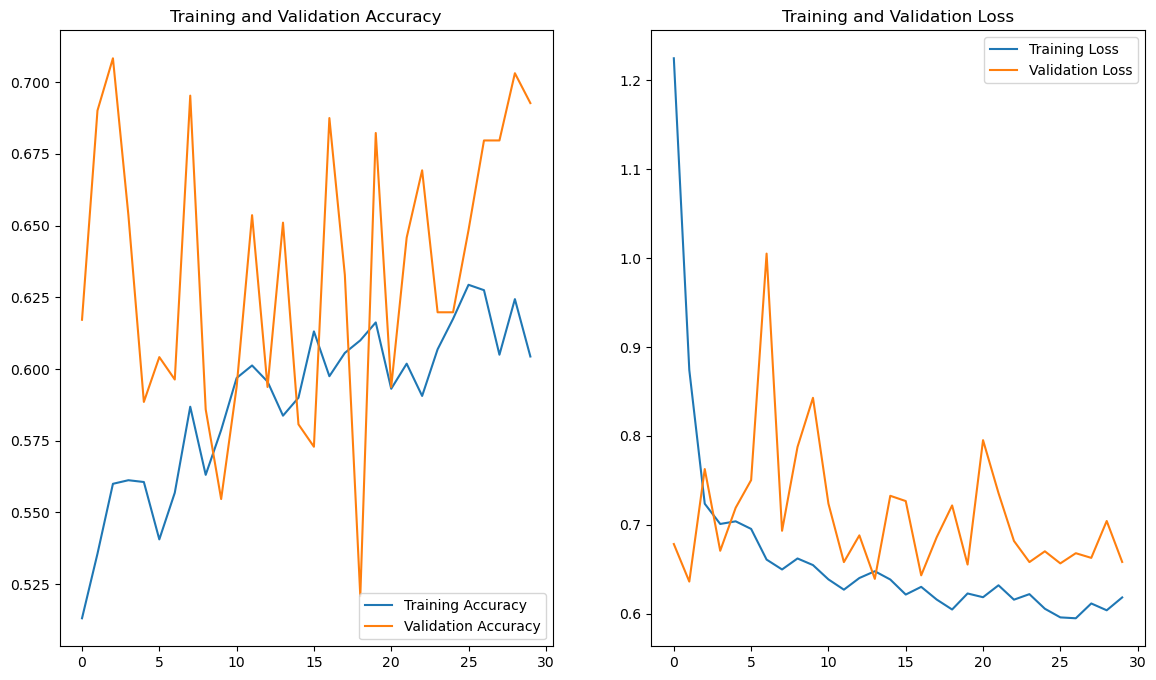

In [81]:
# Plot the model history.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 4. Hyperparameter tuning

In [ ]:
# Implement the Keras EarlyStopping callback.
early_stop = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

In [83]:
# Hyperparameter options.
batch_sizes = [64, 32]
learning_rates = [0.001, 0.0005]
dropout_rates = [0.1, 0.2, 0.3]

# Create hyperparameter grid.
hyperparameter_grid = list(product(batch_sizes, learning_rates, dropout_rates))

In [84]:
# Rough parameter search.
epochs = 30

total_iterations = len(hyperparameter_grid)
results = []  # List to store results from each run.

print(f"Total iterations: {total_iterations}")

for idx, (batch_size, lr, dropout_rate) in enumerate(hyperparameter_grid):
    print(f"\nRunning: batch_size={batch_size}, learning_rate={lr}, dropout_rate={dropout_rate}")
    
    # Build the model with the current hyperparameters.
    model = models.transfer_model(
    base_model,
    dropout_rate=dropout_rate,
    dense_unit=256,
    lr=lr,
    metrics=metrics)
    
    # Train the model.
    history = model.fit(
        train_data_gen,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size,
        callbacks=[early_stop],
        verbose=0  # Reduce training output during tuning.
    )
    
    # Find the best validation accuracy and the corresponding epoch.
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    final_val_loss = history.history['val_loss'][best_epoch - 1]
    
    # Append hyperparameters and performance metrics to the results.
    results.append({
        'batch_size': batch_size,
        'learning_rate': lr,
        'dropout_rate': dropout_rate,
        'best_val_accuracy': best_val_acc,
        'best_epoch': best_epoch,
        'final_val_loss': final_val_loss 
    })
    print(f"Completed: best_val_accuracy={best_val_acc:.4f} at epoch {best_epoch}")

    print(idx + 1, "/", total_iterations, end="\r")  # Print progress.

# Move to a new line after the progress bar.
print("\nHyperparameter tuning complete.")

Total iterations: 12

Running: batch_size=64, learning_rate=0.001, dropout_rate=0.1
Completed: best_val_accuracy=1.0000 at epoch 2
1 / 12
Running: batch_size=64, learning_rate=0.001, dropout_rate=0.2
Completed: best_val_accuracy=1.0000 at epoch 6
2 / 12
Running: batch_size=64, learning_rate=0.001, dropout_rate=0.3
Completed: best_val_accuracy=0.9948 at epoch 5
3 / 12
Running: batch_size=64, learning_rate=0.0005, dropout_rate=0.1
Completed: best_val_accuracy=0.9844 at epoch 2
4 / 12
Running: batch_size=64, learning_rate=0.0005, dropout_rate=0.2
Completed: best_val_accuracy=0.7344 at epoch 2
5 / 12
Running: batch_size=64, learning_rate=0.0005, dropout_rate=0.3
Completed: best_val_accuracy=1.0000 at epoch 2
6 / 12
Running: batch_size=32, learning_rate=0.001, dropout_rate=0.1
Completed: best_val_accuracy=0.6484 at epoch 8
7 / 12
Running: batch_size=32, learning_rate=0.001, dropout_rate=0.2
Completed: best_val_accuracy=0.7057 at epoch 9
8 / 12
Running: batch_size=32, learning_rate=0.001, dr

In [85]:
# Create a DataFrame from the results and save to CSV.
df_results = pd.DataFrame(results)
csv_filename = "../results/hyperparameter_tuning_results_transfer.csv"
df_results.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

Results saved to ../results/hyperparameter_tuning_results_transfer.csv


## 5. Train pre-trained model

In [8]:
# Select the best configuration based on highest validation accuracy.
results_csv = "../results/hyperparameter_tuning_results_transfer.csv"
df_results = pd.read_csv(results_csv)

best_config = df_results.sort_values('best_val_accuracy', ascending=False).iloc[0]
best_batch_size = int(best_config['batch_size'])
best_lr = best_config['learning_rate']
best_dropout = best_config['dropout_rate']

print("Best Hyperparameters:")
print(best_config)

Best Hyperparameters:
batch_size           64.000000
learning_rate         0.001000
dropout_rate          0.100000
best_val_accuracy     0.968750
best_epoch            2.000000
final_val_loss        0.240565
Name: 0, dtype: float64


In [9]:
# Final model
best_model = models.transfer_model(
    base_model,
    dropout_rate=best_dropout,
    dense_unit=256,
    lr=best_lr,
    metrics=metrics)

best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,155,393 (92.15 MB)

 Trainable params: 590,593 (2.25 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

In [14]:
total_train_and_val = train_and_val_data_gen.samples

print(f"total_train_and_val: {total_train_and_val}")
print(f"batch_size: {best_batch_size}")
print(f"steps_per_epoch: {total_train_and_val // best_batch_size}")

total_train_and_val: 2000
batch_size: 64
steps_per_epoch: 31


In [26]:
# Retraining the model using the complete training dataset (including the validation dataset).
best_epoch = 2

history_full = best_model.fit(
    train_and_val_data_gen,
    batch_size=best_batch_size,
    steps_per_epoch=total_train_and_val // best_batch_size,
    epochs=best_epoch,
)

Epoch 1/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.5396 - loss: 0.6810
Epoch 2/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 12s 374ms/step - accuracy: 0.5657 - loss: 0.6724


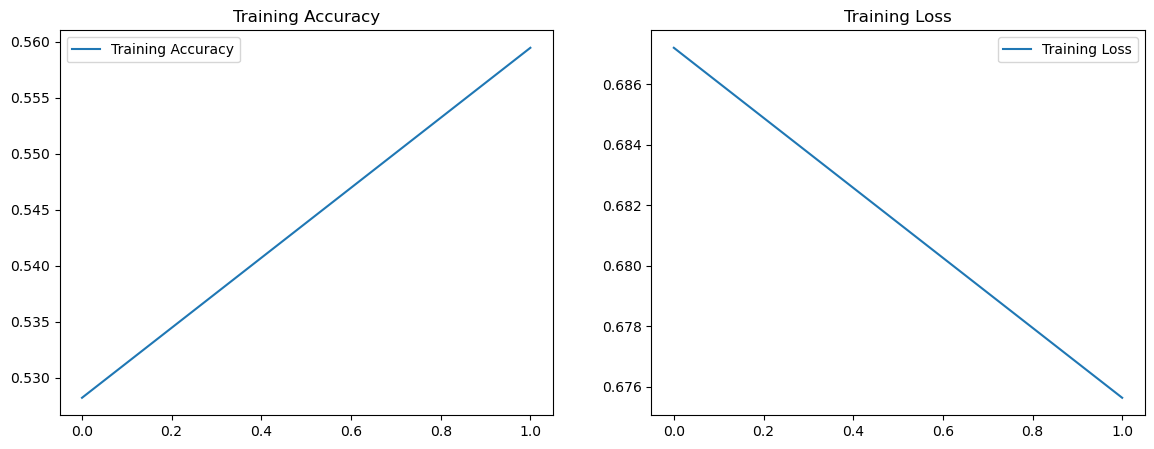

In [28]:
# Retrieve only the training history.
acc = history_full.history['accuracy']
loss = history_full.history['loss']
epochs_range = range(best_epoch)

# Plot only the training curves.
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [29]:
# Save the retrained model to disk.
model_save_path = "../results/final_transfer.keras"

best_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to ../results/final_transfer.keras


In [30]:
# Reload the model from disk.
reloaded_model = load_model(model_save_path)
print("Model loaded from disk.")

Model loaded from disk.


In [31]:
# Evaluate the reloaded model on the test set.
test_loss, test_accuracy = reloaded_model.evaluate(
    test_data_gen,
    verbose=1,
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 357ms/step - accuracy: 0.7041 - loss: 0.5855
Test Loss: 0.6853
Test Accuracy: 0.6100


In [32]:
# Generate predictions on the entire test set.
predictions = reloaded_model.predict(
    test_data_gen, 
    verbose=1
)

# For binary classification, use a threshold of 0.5.
predictions_class = (predictions >= 0.5).astype(int).flatten()

# Get ground truth labels from the generator.
true_labels = test_data_gen.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 537ms/step


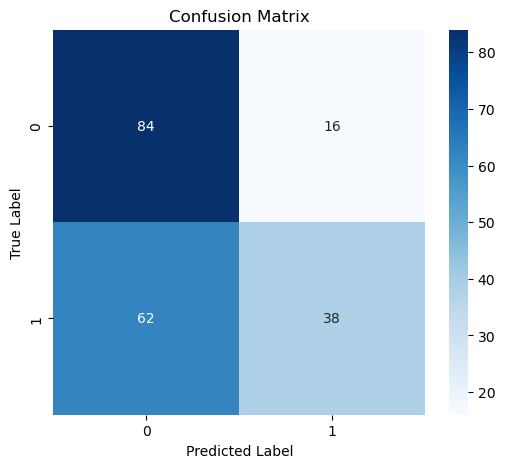

In [33]:
### not part of the assignment

# Compute the confusion matrix.
cm = confusion_matrix(true_labels, predictions_class)

# Plot the confusion matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Fine-tuning the entire model

In [115]:
# Unfreeze part of the base model.
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

base_model.trainable = True
#for layer in base_model.layers[:-10]:
#    layer.trainable = False

best_model_fine_tuned = models.transfer_model(
    base_model,
    dropout_rate=best_dropout,
    dense_unit=256,
    lr=best_lr,
    metrics=metrics)

best_model_fine_tuned.summary()

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 4, 4, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 4, 4, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_29     │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,155,393 (92.15 MB)

 Trainable params: 24,109,953 (91.97 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [116]:
# Retrain the whole model.
epochs_full = 2

history_full = best_model_fine_tuned.fit(
    train_and_val_data_gen,
    batch_size=best_batch_size,
    steps_per_epoch=total_train_and_val // best_batch_size,
    epochs=epochs_full,
)

Epoch 1/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - accuracy: 0.5888 - loss: 0.7041
Epoch 2/2
31/31 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - accuracy: 0.5516 - loss: 0.7734


How do you even evaluate a drop in performance on the training dataset if the loss/accuracy always decreases/increases? Currently I made the next questions for both models (see previous section), the fine tuned version performs worse. Normally we are only allowed to use the test set once at the end but I see no other way to evaluate.

In [117]:
# Save the retrained model to disk.
model_save_path = "../results/final_transfer_fine_tuned.keras"

best_model_fine_tuned.save(model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to ../results/final_transfer_fine_tuned.keras


In [118]:
# Reload the model from disk.
reloaded_model = load_model(model_save_path)
print("Model loaded from disk.")

Model loaded from disk.


In [119]:
# Evaluate the reloaded model on the test set.
test_loss, test_accuracy = reloaded_model.evaluate(
    test_data_gen, 
    verbose=1,
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 476ms/step - accuracy: 0.5435 - loss: 0.9239
Test Loss: 0.7215
Test Accuracy: 0.6650


In [120]:
# Generate predictions on the entire test set.
predictions = reloaded_model.predict(
    test_data_gen, 
    verbose=1
)

# For binary classification, use a threshold of 0.5.
predictions_class = (predictions >= 0.5).astype(int).flatten()

# Get ground truth labels from the generator.
true_labels = test_data_gen.classes

7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 771ms/step


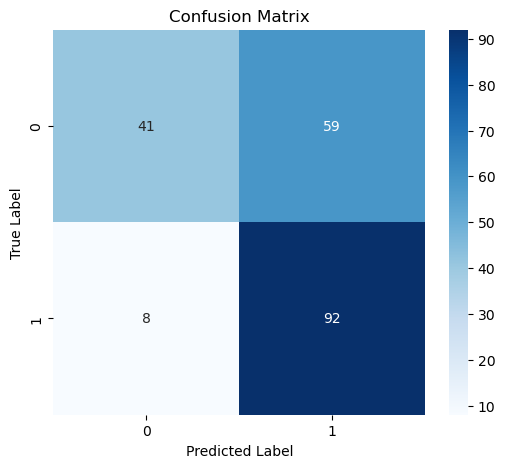

In [121]:
# Compute the confusion matrix.
cm = confusion_matrix(true_labels, predictions_class)

# Plot the confusion matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

Found 1600 files belonging to 2 classes.
Found 400 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


NameError: name 'labels' is not defined

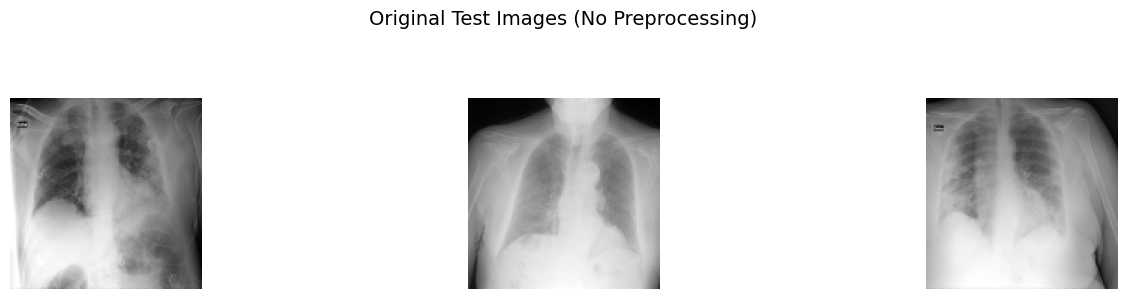

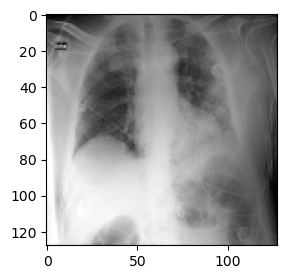

In [ ]:
# Create a test data generator WITHOUT normalization (already done)
_, _, _, test_data_gen_no_norm = loading.get_images(
    path, 
    img_height, 
    img_width, 
    batch_size)

# Extract original (non-normalized) images
images, _, _ = loading.generator_to_array(test_data_gen_no_norm)

# Plot the same random sample of images — no labels, no predictions
num_images_to_plot = 3
images_to_plot = random.sample(range(100), num_images_to_plot)  # or use a fixed list to match earlier ones

plt.figure(figsize=(15, 3))
for i, idx in enumerate(images_to_plot):
    plt.subplot(1, num_images_to_plot, i+1)
    plt.imshow(images[idx].astype("uint8"), cmap="gray")  # use "gray" only for grayscale images
    plt.axis('off')
plt.suptitle("Original Test Images (No Preprocessing)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.85])



# Normalize the images
imagess = preprocessing.normalize_images(images) 

plt.figure(figsize=(15, 3))
for i, idx in enumerate(images_to_plot):
    plt.subplot(1, num_images_to_plot, i+1)

    # Rescale normalized image back to [0,255] for visualization
    img = (imagess[idx].numpy() * 255).astype("uint8")

    plt.imshow(img, cmap="gray") 
    true_label = labels[idx]
    pred_label = test_data_gen.class_names[predictions_class[idx]]
    
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10)
    plt.axis('off')
plt.suptitle("Sample Test Images (After Preprocessing) with Model Predictions", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()


## Questions

**Question 13:** *How did you choose the architecture for the final layers you added to the pretrained
model?*

They are exactly the same fully connected layers as the previous model.

---

**Question 14:** *How did the pre-trained model’s training curve compare to the final baseline model’s
from Task 4.4?*

It has a much lower accuracy but the loss curve goes down as well but not to such a small value as in the baseline.

---

**Question 15:** *Did fine-tuning the entire model improve model performance? How small did you
have to make your learning rate to avoid a drop in performance?*

If we validate the performance on the accuracy the model has on the test data then we indeed imporved the model performance and we did not have to lower the learning rate.

---

**Question 16:** *How did your fine-tuned model’s performance compare to the final baseline model’s
from Task 4.4?*

It performed worse (89% -> 67% accurate). 

---

**Question 17:** *Based on this experience, what are the advantages and disadvantages of transfer
learning?*

Advantages: Training is faster at the same amount of data .
Disadvantages: The base model and its predefined weights might not be suitable for the task and fine tuning is a tricky process.

---

**Question 18:** *What could be done differently from the proposed transfer learning approach to
strengthen its effectiveness?*

The base model and its predefined weights were trained on rgb images of various objects but not grayscale medical images. Using a different model and pretrained weights that are suited for the task would increase the effectiveness of the approach.